# Applying DMD for transient modeling, surrogates and Uncertainty Quantificaton.

## 2D LRA Benchmark: 

In this test case, a control rod ejection in the 2D well known LRA benchmark has been simulated by Detran (developed by J. A. Roberts). The objective here is to build a data-driven, yet physics-revealing time-dependent surrogate model(s). The linearity inherited from the connection to Koopman theory will facilitate a forward/backward uncertainty propagation. 

First of all, lets make the necessary imports including the DMD class from PyDMD (developed by math)we import the DMD class from the pydmd package, we set matplotlib for the notebook and we import numpy.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import scipy as sp
from pydmd import DMD_jov
import pickle

In [2]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times'

#plt.rcParams['mathtext.fontset'] = 'custom'
#plt.rcParams['mathtext.rm'] = 'Times New Roman'
#plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
#plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 20
#plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.frameon'] = False

plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0

plt.rcParams['text.usetex'] = True

plt.rcParams['savefig.bbox'] = 'tight'

We load the Detran simulation data of the Transient LRA Benchmark

In [3]:
A = pickle.load(open('../inputs/diffusion2x2_ref_with_mesh_temps.p','rb'),encoding='latin')

kappa = 3.204e-11

In [4]:
#%% Plots of raw data
t = np.array(A['times'])   # time
mp = np.array(A['meshpower']).T # mesh-dependent powers
mp = mp * kappa
p = np.array(A['power'])# total power
c = p[0]/sp.sum(mp,axis=0)[0]# use to reconstruct power from mesh power
maxtemp = A['maxtemp']#
np.where(p==max(p))
#mp = mp * c

(array([143]),)

Build the surrogates using a batch of DMD's

In [5]:
#%%  DMD analysis
import time
et_0 = time.time()
# Time step
dt = t[1]-t[0]
# Chop the time domain into discrete patches
time_interval = [1.36,1.5,max(t)]
# Define desire subspace size for each patch
r = [10,13,40]
#r = [50,1e5,15]
#step=[10,1,1]
optimal=['Jov',False,False]
# Perform dmd
time_index = [0]
for i in range(len(time_interval)):
    time_index.append(sp.sum(t<=time_interval[i]))

F_norm = 0.0
results={}
for i in range(len(time_interval)):
    start, stop = time_index[i], time_index[i+1]
    t_i = t[start:stop]
    dmd = DMD_jov(svd_rank=r[i],opt=optimal[i])   
    fuel_idx = mp[:, 0]>0                  # pick out fuel mesh
    tmp_reduced = mp[fuel_idx, start:stop] # extract fuel data
    tmp_full = 0*mp[:, start:stop]  # initialize full data
    dmd.fit(tmp_reduced)              # do the fit
    tmp_full[fuel_idx] = dmd.reconstructed_data.real
    results[i]={}
    results[i]['dmd'] = dmd
    results[i]['t'] = t_i # All the coming lines can be ommitted except p_dmd
    results[i]['Phi'] = dmd.modes
    results[i]['eigs'] = dmd.eigs
    results[i]['mp_dmd'] = tmp_full.copy()#dmd.reconstructed_data
    results[i]['p_dmd'] = sp.zeros(stop-start)
    results[i]['p_dmd'] = c*sp.sum(tmp_full, axis=0)# c*sp.sum(dmd.reconstructed_data.real,axis=0)
    F_norm_tmp = np.linalg.norm(tmp_reduced-dmd.reconstructed_data.real)
    print("patch {} norm = {:.2e}".format(i, F_norm_tmp))
    F_norm += F_norm_tmp**2
  
et = time.time() - et_0

F_norm = np.sqrt(F_norm)
print("final norm is {:.2e}".format(F_norm))

print('elapsed time = ', et)

patch 0 norm = 3.11e-03
patch 1 norm = 6.64e-01
patch 2 norm = 4.31e+04
final norm is 4.31e+04
elapsed time =  0.021336793899536133


/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/pydmd-0.1.0-py3.6.egg/pydmd/dmd_jov.py:69: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(modes, snapshots.T[0])[0]


/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWa

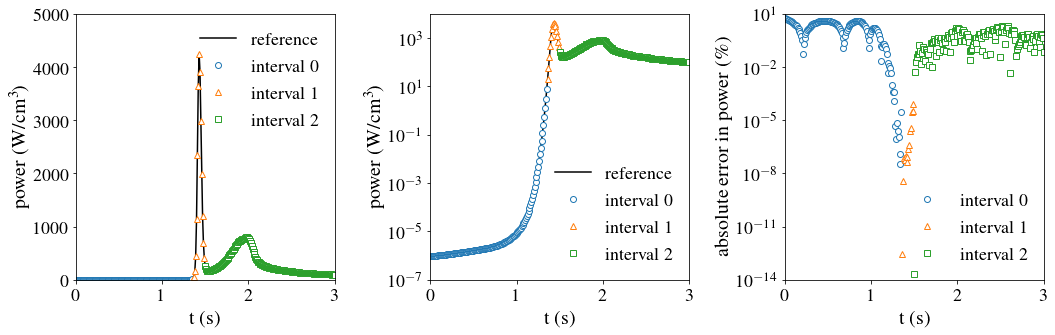

In [6]:
#for mode in dmd.modes.T:
#    plt.plot(x, mode.real)
#    plt.title('Modes')
#plt.show()T.real)
    
#plt.pcolor(xgrid, tgrid, ((mp[start:stop, :].T-dmd.reconstructed_data).T).real)
#fig = plt.colorbar()

markers = ['o', '^', 's', 'v']

fig5=plt.figure(figsize=(15,5))

# Plot the surrogate and reference on a linear plot
ax1=fig5.add_subplot(1,3,1)
plt.plot(t, p, 'k-', label='reference')
for k in range(len(time_interval)):
    plt.plot(results[k]['t'], results[k]['p_dmd'].real, marker=markers[k], ls='', mfc='w', label='interval '+str(k))    
plt.axis([0, 3, 0, 5000])
plt.xlabel('t (s)')
plt.ylabel('power (W/cm$^3$)')
plt.legend(loc="upper right")

# Plot the surrogate and reference on a log plot.  Put the derivative on the other axis.
ax2=fig5.add_subplot(1,3,2)  
plt.semilogy(t, p, 'k-', label='reference')
for k in range(len(time_interval)):
    plt.semilogy(results[k]['t'], results[k]['p_dmd'].real, marker=markers[k], ls='', mfc='w', label='interval '+str(k))
plt.xlabel('t (s)')
plt.ylabel('power (W/cm$^3$)')
dpdt = np.gradient(p, t)
idx_pos = dpdt>0
idx_neg = dpdt<0
#ax2left = ax2.twinx()
#plt.semilogy(t, abs(dpdt), 'r:', label='derivative')
plt.legend()

#plt.legend()

# Plot the error
ax2=fig5.add_subplot(1,3,3)  
t_start = 0
for k in range(len(time_interval)):
    t_end = t_start + len(results[k]['t'])
    ref = p[t_start:t_end]
    err = abs(results[k]['p_dmd'].real-ref)/ref*100
    plt.semilogy(t[t_start:t_end], err, marker=markers[k], 
                 ls='', mfc='w', label='interval '+str(k))
    t_start = t_end
plt.xlabel('t (s)')
plt.ylabel('absolute error in power (\%)')
plt.legend()

plt.tight_layout()
plt.savefig('../images/corepower.pdf')

165.0

/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


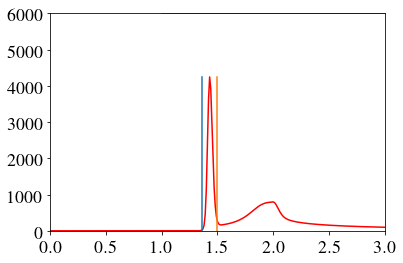

In [7]:
#plt.semilogy(t[idx_pos], dpdt[idx_pos], 'r.', ms=2)
d2pdt2 = np.gradient(dpdt, t)
ff = abs(p)
plt.plot(t, ff, 'r-',
            [time_interval[0],time_interval[0]], [min(ff), max(ff)],
            [time_interval[1], time_interval[1]], [min(ff), max(ff)],
            [1, 3], [6e3, 6e3])

#plt.axis([1.3, 1.6, min(ff)/5, max(ff)/5])
t[p==max(p[t>1.6])]
t[143]

np.sqrt(mp.shape[0])*7.5

In [8]:
Xdmd_2D=np.reshape(np.concatenate((results[0]['mp_dmd'],results[1]['mp_dmd'],results[2]['mp_dmd']),axis=1),(22,22,-1),order='F')
mp_2D=np.reshape(mp,(22,22,-1),order='F')

In [9]:
X_lim = 21*7.5
X,Y=np.linspace(0,X_lim,22),np.linspace(0,X_lim,22)

In [10]:
xgrid,ygrid=np.meshgrid(X,Y)

In [11]:
Xdmd_2D[:,:,0].shape,mp_2D[:,:,0].shape
E = abs(mp_2D.real-Xdmd_2D.real)/mp_2D.real*100
E[mp_2D==0]=0

/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/robertsj/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


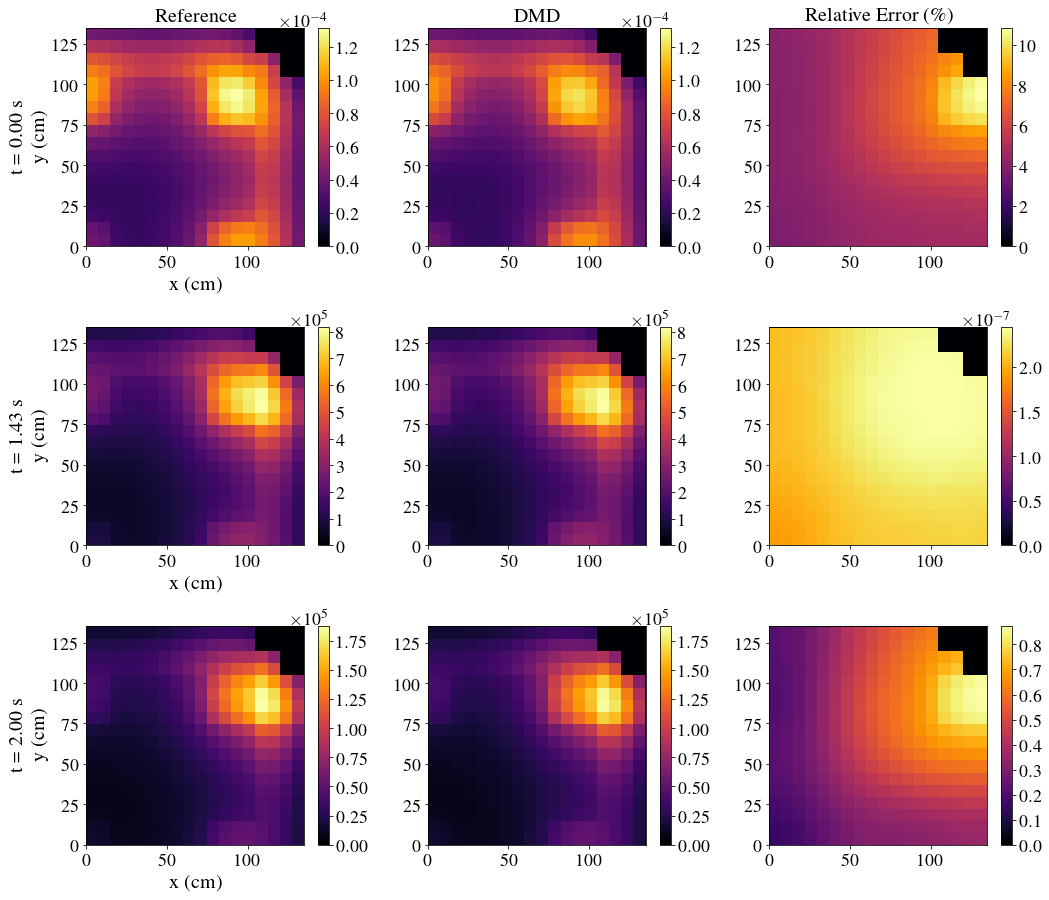

In [12]:
## print('t=0')
fig = plt.figure(figsize=(15,12.75))

steps = 0, 143, 200
color = 'inferno'
for i in range(len(steps)):
    
    ax1=fig.add_subplot(3,3,3*i+1)
    ax1.set_aspect('equal')
    vmax = max(np.max(mp_2D[:,:,steps[i]]), np.max(Xdmd_2D[:,:,steps[i]].real))
    vmin = 0.0#min(np.min(mp_2D[:,:,steps[i]]>0), np.min(Xdmd_2D[:,:,steps[i]].real>0))
    plot = plt.pcolor(xgrid, ygrid, mp_2D[:,:,steps[i]].real.T,cmap=color,  
                      vmin=vmin, vmax=vmax, rasterized=True, linewidth=0)
    plot.set_edgecolor('face')

    cbar = fig.colorbar(plot)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    if i == 0:
        plt.title('Reference')
    plt.xlabel('x (cm)')
    plt.ylabel('t = {:.2f} s \ny (cm)'.format(t[steps[i]]))
    plt.axis([0, 135, 0, 135])

    ax2=fig.add_subplot(3,3,3*i+2)
    ax2.set_aspect('equal')
    plt.axis([0, 135, 0, 135])
    plot=plt.pcolor(xgrid, ygrid, Xdmd_2D[:,:,steps[i]].real.T,cmap=color,  
                      vmin=0, vmax=vmax, rasterized=True, linewidth=0)
    cbar = fig.colorbar(plot)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    if i == 0:
        plt.title('DMD')

    ax3=fig.add_subplot(3,3,3*i+3)
    ax3.set_aspect('equal')
    plt.axis([0, 135, 0, 135])
    plt.pcolor(xgrid, ygrid, E[:,:,steps[i]].T,cmap=color,  
               rasterized=True, linewidth=0)
    plt.colorbar()
    if i == 0:
        plt.title('Relative Error (\%)')

plt.tight_layout()
plt.savefig('../images/meshpower.pdf')

In [13]:
p[0]

1.0000000000000002e-06

In [14]:
p[0]/sum(mp[:, 0])*17550.0

1.0000000000000013

In [15]:
sum(mp[:,0]), p[0]*17550.0

(0.01754999999999998, 0.017550000000000003)